# Assignment1. Softmax and 2-layer Neural Network classifier

In [472]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import time

# set default plot options
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Set up input preprocessing

You need to download the data from the CIFAR-10 website. To do this, simply run following command, and then load dataset.

In [6]:
# Prepare the input dataset.
!./get_cifar10.sh

--2017-11-08 10:07:58--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  1.38MB/s    in 61s     

2017-11-08 10:09:00 (2.68 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

Unziopping datasets...
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
Done.


In [473]:
# Load all of CIFAR10 dataset.
def load_CIFAR10(root):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(root, 'data_batch_%d' % (b, ))
        with open(f, 'rb') as f:
            datadict = pickle.load(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
        #X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X,Y
    
    f=os.path.join(root, 'test_batch')
    with open(f, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        Xte = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        Yte = np.array(Y)
        
    return Xtr, Ytr, Xte, Yte

In [474]:
def get_CIFAR10_data():
    # 1. Load the raw data
    X_tr, Y_tr, X_te, Y_te = load_CIFAR10('./cifar-10-batches-py')
    
    # 2. Divide the data
    X_val, Y_val = X_tr[49000:], Y_tr[49000:]
    X_tr, Y_tr = X_tr[:49000], Y_tr[:49000]
    X_te, Y_te = X_te[:1000], Y_te[:1000]

    # 3. Preprocess the input image
    X_tr = np.reshape(X_tr, (X_tr.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0],-1))
    X_te = np.reshape(X_te, (X_te.shape[0],-1))
    
    # 4. Normalize the data (subtract the mean image)
    mean_img = np.mean(X_tr, axis=0)
    X_tr -= mean_img
    X_val -= mean_img
    X_te -= mean_img
    
    # 5. Add bias and Transform into columns
    X_tr = np.hstack([X_tr, np.ones((X_tr.shape[0],1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0],1))])
    X_te = np.hstack([X_te, np.ones((X_te.shape[0],1))])
    
    return X_tr, Y_tr, X_val, Y_val, X_te, Y_te



X_tr, Y_tr, X_val, Y_val, X_te, Y_te = get_CIFAR10_data()
print 'Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape)
print 'Validatoin data shape : %s,  Validation labels shape : %s' % (X_val.shape, Y_val.shape)
print 'Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape)

Train data shape : (49000, 3073),  Train labels shape : (49000,)
Validatoin data shape : (1000, 3073),  Validation labels shape : (1000,)
Test data shape : (1000, 3073),  Test labels shape : (1000,)


# 1. Softmax Classifier

We will implement two version of loss functions for softmax classifier, and test it out on the CIFAR10 dataset.

First, implement the naive softmax loss function with nested loops.

In [475]:
def softmax_loss_naive(W,X,Y,reg):
    """
     Inputs have D dimension, there are C classes, and we operate on minibatches of N examples.
    
     Inputs :
         - W : A numpy array of shape (D,C) containing weights.
         - X : A numpy array of shape (N,D) contatining a minibatch of data.
         - Y : A numpy array of shape (N,) containing training labels; 
               Y[i]=c means that X[i] has label c, where 0<=c<C.
         - reg : Regularization strength. (float)
         
     Returns :
         - loss as single float
         - gradient with respect to weights W; an array of sample shape as W
     """
    
    # Initialize the loss and gradient to zero
    loss = 0.0
    dW = np.zeros_like(W)
    
    ####################################################################################################
    # TODO : Compute the softmax loss and its gradient using explicit loops.                           # 
    #        Store the loss in loss and the gradient in dW.                                            #
    #        If you are not careful here, it is easy to run into numeric instability.                  #
    #        Don't forget the regularization.                                                          #
    #---------------------------------------WRITE YOUR CODE--------------------------------------------#
    C = W.shape[1]
    N = X.shape[0]
    D = W.shape[0]
    
    #W = W.T
    #X = X.T
    output = 0
    loss_norm = 0
    sofmax =0
    for i in range(N):
        loss_norm = 0
        output = X[i].dot(W)
        output -= np.max(output)
        #output = np.exp(output) # (C)
        #print output.shape
        for loss_ in output:
            loss_norm += np.exp(loss_)
        #loss_ = output/loss_norm    
        loss += np.log(loss_norm) - output[Y[i]] 
        #output[Y[i]] -= 1
        #gradient
        for j in range(C):
            p = np.exp(output[j])/loss_norm
            dW[:,j] += (p - (j == Y[i])) * X[i,:]
    loss /= N
    dW /= N
    loss += reg * np.sum(W*W)
    dW += reg * W

    
    #--------------------------------------END OF YOUR CODE--------------------------------------------#
    ####################################################################################################
    return loss, dW

Generate a random softmax weight matrix and use it to compute the loss. As a rough sanity check, our loss should be something close to -log(0.1).

The next thing is the vectorized softmax loss function.

In [476]:
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_tr, Y_tr, 0.0)

print 'loss :', loss
print 'sanity check : ', -np.log(0.1)

loss : 2.39861934003
sanity check :  2.30258509299


Compare two versions. The two versions should compute the same results, but the vectorized version should be much faster.

In [477]:
def softmax_loss_vectorized(W, X, Y, reg):
    loss = 0.0
    dW = np.zeros_like(W)

    ####################################################################################################
    # TODO : Compute the softmax loss and its gradient using no explicit loops.                        # 
    #        Store the loss in loss and the gradient in dW.                                            #
    #        If you are not careful here, it is easy to run into numeric instability.                  #
    #        Don't forget the regularization.                                                          #
    #---------------------------------------WRITE YOUR CODE--------------------------------------------#

    N = X.shape[0]
    output =np.dot(W.T, X.T)
    #print output.shape
    output = output.T
    output -= np.max(output, axis=1, keepdims=True) # N, C
    
    #print output.shape
    output_exp = np.exp(output)
  
    output_sum = (np.sum(np.exp(output), axis=1, keepdims=True))
    
    prob = output_exp/output_sum # each row divide by a vector
    #print output_exp.shape, output_sum.shape, prob.shape
    output_elements = prob[range(N), Y]
    loss = np.sum(-np.log(output_elements))/N
    #loss = np.sum(loss_normalized)
    
    prob[range(N), Y] -= 1
    
    
    dW = prob.T.dot(X)
    #grad += reg * W
    dW /= N
    dW = dW.T
    dW += reg*W
    
    loss += reg * np.sum(W * W)
    
    
    
    #--------------------------------------END OF YOUR CODE--------------------------------------------#
    ####################################################################################################
    
    return loss, dW

In [478]:
s_time = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_tr, Y_tr, 0.00001)
print 'naive loss : %e with %fs' % (loss_naive, time.time()-s_time)

s_time = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_tr, Y_tr, 0.00001)
print 'vectorized loss : %e with %fs' % (loss_vectorized, time.time()-s_time)

print 'loss difference : %f' % np.abs(loss_naive - loss_vectorized)
print 'gradient difference : %f' % np.linalg.norm(grad_naive-grad_vectorized, ord='fro')

naive loss : 2.398619e+00 with 14.804347s
vectorized loss : 2.398619e+00 with 0.576204s
loss difference : 0.000000
gradient difference : 0.000000


Now, you should implement the softmax classifier using the comment below with softmax loss function you implemented above.

In [479]:
class Softmax(object):
    def __init__(self):
        self.W = None
        
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        """
        Train this Softmax classifier using stochastic gradient descent.
        
        Inputs have D dimensions, and we operate on N examples.
        
        Inputs :
            - X : A numpy array of shape (N,D) containing training data.
            - Y : A numpy array of shape (N,) containing training labels;
                  Y[i]=c means that X[i] has label 0<=c<C for C classes.
            - learning_rate : (float) Learning rate for optimization.
            - reg : (float) Regularization strength. 
            - num_iters : (integer) Number of steps to take when optimizing. 
            - batch_size : (integer) Number of training examples to use at each step.
            - verbose : (boolean) If true, print progress during optimization.
        
        Regurns :
            - A list containing the value of the loss function at each training iteration.
        """
        
        num_train, dim = X.shape
        num_classes = np.max(Y)+1
        if self.W is None :
            self.W = 0.001*np.random.randn(dim, num_classes)
            
        loss_history = []
        for it in xrange(num_iters):
            X_batch = None
            Y_batch = None
            
        ####################################################################################################
        # TODO : Sample batch_size elements from the training data and their corresponding labels          #
        #        to use in this round of gradient descent.                                                 #
        #        Store the data in X_batch and their corresponding labels in Y_batch; After sampling       #
        #        X_batch should have shape (dim, batch_size) and Y_batch should have shape (batch_siae,)   #
        #                                                                                                  #
        #        Hint : Use np.random.choice to generate indicies.                                         #
        #               Sampling with replacement is faster than sampling without replacement.             #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        index = np.random.choice(num_train, batch_size, replace=True)
        X_batch = X[index, :]
        Y_batch = Y[index]
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################

        # Evaluate loss and gradient
        loss, grad = self.loss(X_batch, Y_batch, reg)
        loss_history.append(loss)
        
        # Perform parameter update
        ####################################################################################################
        # TODO : Update the weights using the gradient and the learning rate                               #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        self.W -= grad * learning_rate
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        
        if verbose and it % num_iters == 0:
            print 'Ieration %d / %d : loss %f ' % (it, num_iters, loss)
        
    
    def predict(self, X):
        """
        Use the trained weights of this softmax classifier to predict labels for data points.
        
        Inputs :
            - X : A numpy array of shape (N,D) containing training data.
            
        Returns :
             - Y_pred : Predicted labels for the data in X. Y_pred is a 1-dimensional array of length N, 
                        and each element is an integer giving the predicted class.
        """
        Y_pred = np.zeros(X.shape[0])
        
        ####################################################################################################
        # TODO : Implement this method. Store the predicted labels in Y_pred                               #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        output = np.dot(X,self.W) #N,C
        output -= np.max(output)
        Y_pred = np.argmax(output, axis=1)
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        return Y_pred
    
    
    def loss(self, X_batch, Y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, Y_batch, reg)

Use the validatoin set to tune hyperparemeters (regularizatoin strength and learning rate).
You should experiment with different range for the learning rates and regularization strength;
if you are careful you should be able to get a classification accuracy of over 0.35 on the validatoin set.

In [480]:
# results is dictionary mapping tuples of the form.
# (learning_rate, regularization_strength) to tuple of the form (training_accuracy, validation_accuracy).
# The accuracy is simply the fraction of data points that are correctly classified.
softmax = Softmax()

results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-5, 8e-6, 1e4]
regularization_strengths = [2e-4, 6e-2]
num_iter = 5
#########################################################################################################
# TODO : Write code that chooses the best hyperparameters by tuning on the validation set.              # 
#        For each combination of hyperparemeters, train a Softmax on the training set,                  #
#        compute its accuracy on the training and validatoin sets, and store these numbers in the       #
#        results dictionary. In addition, store the best validation accuracy in best_val                #
#        and the Softmax object that achieves this accuracy in best_softmax.                            #
#                                                                                                       #
# Hint : You should use a small value for num_iters as you develop your validation code so that the     #
#        Softmax don't take much time to train; once you are confident that your validation code works, #
#        you should rerun the validation code with a larger value for num_iter.                         #
#------------------------------------------WRITE YOUR CODE----------------------------------------------#
for i in range(num_iter):
    for lr in learning_rates:
        for rs in regularization_strengths:
            #Calling object
            softmax = Softmax()
        
            softmax.train(X_tr, Y_tr, learning_rate=lr, reg=rs, num_iters=130000, batch_size=200, verbose=False)
            Y_pred = softmax.predict(X_tr)
            Y_val_pred = softmax.predict(X_val)
        
            train_acc = np.mean(Y_tr == Y_pred)
            val_acc = np.mean(Y_val == Y_val_pred)
            results[(lr, rs)] = (train_acc, val_acc)
            if val_acc > best_val:
                best_softmax = softmax
                best_val = val_acc
        
        
#-----------------------------------------END OF YOUR CODE----------------------------------------------#
#########################################################################################################

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy : %f, val accuracy : %f ' % (lr, reg, train_accuracy, val_accuracy)
    
print 'best validatoin accuracy achieved during cross-validation :', best_val

lr 8.000000e-06 reg 2.000000e-04 train accuracy : 0.172612, val accuracy : 0.174000 
lr 8.000000e-06 reg 6.000000e-02 train accuracy : 0.161490, val accuracy : 0.152000 
lr 5.000000e-05 reg 2.000000e-04 train accuracy : 0.134673, val accuracy : 0.140000 
lr 5.000000e-05 reg 6.000000e-02 train accuracy : 0.181224, val accuracy : 0.181000 
lr 1.000000e+04 reg 2.000000e-04 train accuracy : 0.154347, val accuracy : 0.157000 
lr 1.000000e+04 reg 6.000000e-02 train accuracy : 0.186408, val accuracy : 0.179000 
best validatoin accuracy achieved during cross-validation : 0.199


Evaluate the best softmax on testset.

In [481]:
Y_te_pred = best_softmax.predict(X_te)
test_accuracy = np.mean(Y_te == Y_te_pred)

print 'softmax on raw pixels final test set accuracy : ', test_accuracy

softmax on raw pixels final test set accuracy :  0.204


Visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

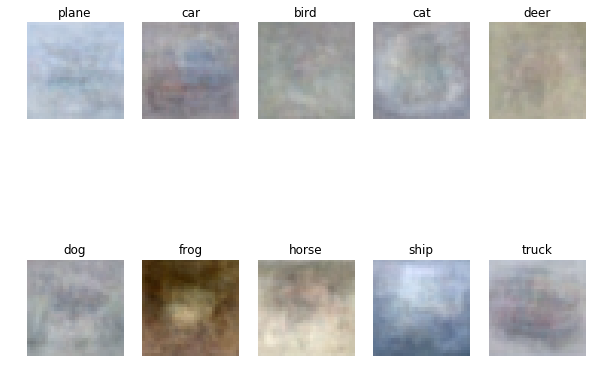

In [482]:
w = best_softmax.W[:-1, :]
w = w.reshape(32,32,3,10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2,5,i+1)
    
    wimg=255.0*(w[:,:,:,i].squeeze() - w_min)/(w_max-w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# 2. Two layer Neural Network classifier

In this part we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR10 dataset. We will use the class TwoLayerNet to present instances of our network. The network parameters are stored in the instance variable self.params where keys are string parameter names and values are numpy arrays.

Implement all functions in TwoLayerNet class in the sequence listed below.

First, we initialize toy data and a toy model that we will use to develop your implementation.

In [483]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    Y = np.array([0,1,2,2,1])
    return X, Y

net = init_toy_model()
X, Y = init_toy_data()

In [484]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of N,
    a hidden layer dimension of H, and performs clasisfication over C classes.
    We train the network with a softmax loss function and L2 regularization on the weight matrices.
    The network uses a ReLU nonlinearity after the first fully connected layer.
    
    In other words, the network has the following architecture :
        input - fully connected layer - ReLU - fully connected layer - softmax
    
    The outputs of the second fully-connected layer are the scores for each class.
    """
    
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and biases are 
        initialized to zero. Weights and biases are stored in the variable self.params, which is 
        a dictionary with the following keys:
        
            W1 : First layer weights ; has shape (D,H)
            b1 : First layer biases ; has shape (H,)
            W2 : Second layer weights ; has shape (H,C)
            b2 : Second layer biases ; has shape (C,)

        Inputs:
            - input_size : The dimension D of the input data.
            - hidden_size : The number of neurons H in the hidden layer.
            - output_size : The number of classes C.
        """
        self.params={}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def loss(self, X, Y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural network.
        
        Inputs :
            - X : Input data of shape (N,D). Each X[i] is a training sample.
            - Y : Vector of training labels. Y[i] is the label for X[i], and each Y[i] is an integer
                  in the range 0<=Y[i]<C. This parameter is optional; If it is not passed then 
                  we only return scores, and if it is passed then we instead return the loss and gradiens. 
            - reg : Regularization strength.
            
        Returns :
            - If Y is None, return a matrix scores of shape (N,C) where scores [i,c] is the score 
              for the class c on input X[i].
            - If Y is not None, instead return a tuple of :
                * loss : Loss (data loss and regularization loss) for this batch of training samples.
                * grads : Dictionary mapping parameter names to gradients of those parameters 
                          with respect to the loss function ; has the same keys as self.params.
        """
        #Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        #Compute the scores
        scores = None
        ####################################################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. Store the result in    #
        # in the scores variable, which should be an array of shape (N, C).                                #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        hidden_layer = np.maximum(np.dot(X,W1) + b1, 0)#(N,H) with ReLu
        scores = np.dot(hidden_layer, W2) + b2 #(N, C)
        
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        
        
        #If the targets are not given then jump out, we're done.
        if Y is None :
            return scores
        
        
        #Compute the loss
        loss = None
        ####################################################################################################
        # TODO : Finish the forward pass, and compute the loss. This should include both the data loss and #
        # L2 regularization for W1 and W2. Store the result in the variable loss, which should be a scalar.#
        # Use the Softmax classifier loss. So that your results match ours, multiply the regularization    #
        # loss by 0.5.                                                                                     #
        #                                                                                                  #
        # Hint : This function is pretty much the same when you compute the softmax loss. The only         #
        # difference is that we use L2 regularization for W1 and W2.                                       # 
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        
        scores -= np.reshape(np.max(scores, axis = 1), (N, -1))
        exp_scores = np.exp(scores)
        softmax_vector = np.reshape(np.sum(exp_scores, axis=1),(N, -1) )
        softmax_loss = exp_scores/softmax_vector
        
        log_prob = softmax_loss[range(N), Y] #(N,)
        data_loss = log_prob
        
        loss = -np.sum(np.log(data_loss))/N
        loss += (np.sum(W1 * W1) + np.sum(W2 * W2)) * 0.5 * reg
 
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        
        
        #Backward pass : compute gradinets
        grads = {}
        ####################################################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights and biases.            #
        # Store the results in the grads dictionary. For example, grads['W1'] should store the gradient    #
        # on W1, and be a matrix of same size.                                                             #    
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        cost = softmax_loss.T
        cost[Y, range(N)] -= 1
        cost /= N
        
        #backprop according to loss
        backprop1 = np.dot(hidden_layer.T, cost.T) #(1, H)
        
        grads['W2'] = backprop1 + reg*W2
        grads['b2'] = np.sum(cost, axis = 1)
        
        backprop2 = np.dot(cost.T, W2.T) #backprop into hidden layer
        backprop2[hidden_layer <= 0] = 0 # backprop Relu non-linearity
        
        hidden_backprop = np.dot(X.T, backprop2) 
        grads['W1'] = hidden_backprop + reg * W1
        grads['b1'] = np.sum(backprop2, axis = 0)
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        
        return loss, grads
    
    
    
    def train(self, X, Y, X_val, Y_val, learning_rate=1e-3, learning_rate_decay=0.95,
              reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.
        
        Inputs :
            - X : A numpy array of shape (N,D) giving training data.
            - Y : A numpy array of shape(N,) giving training labels; Y[i]=c means that X[i] has label c, 
                  where 0<=c<C.
            - X_val : A numpy array of shape (N_val, D) giving validation data.
            - Y_val : A numpy array of shape (N_val,) giving validation labels.
            - learning_rate : Scalar giving learning rate for optimization.
            - learning_rate_decay : Scalar giving factor used to decay the learning rate.
            - reg : Scalar giving regularization strength.
            - num_iters : Number of steps to take when optimizing.
            - batch_size : Number of training examples to use per step.
            - verbose : boolean; if true print progress during optimization.
        """
        
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train/batch_size,1)
        
        #Use SGD to optimize the parameter in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for it in xrange(num_iters):
            X_batch = None
            Y_batch = None
            
            ################################################################################################
            # TODO: Create a random minibatch of training data and labels, storing then in X_batch and     #
            # Y_batch respectively.                                                                        #
            #-------------------------------------WRITE YOUR CODE------------------------------------------#
            length = len(Y)
            index = np.random.choice(length, batch_size, replace=True)
            X_batch = X[index, :]
            Y_batch = Y[index]
            #------------------------------------END OF YOUR CODE------------------------------------------#
            ################################################################################################
            
            
            #Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, Y=Y_batch, reg=reg)
            loss_history.append(loss)
            
            
            ################################################################################################
            # TODO: Use the gradients in the grads dictionary to update the parameters of the network      #
            # (stored in the dictionary self.params) using stochastic gradient descent. You'll need to use #
            # the gradients stored in the grads dictionary defined above.                                  #
            #-------------------------------------WRITE YOUR CODE------------------------------------------#
            self.params['W1'] -= learning_rate*grads['W1']
            self.params['W2'] -= learning_rate*grads['W2']
            #------------------------------------END OF YOUR CODE------------------------------------------#
            ################################################################################################
            
            if verbose and it % 100 == 0:
                print 'Iteration %d / %d : loss %f ' % (it, num_iters, loss)
                
            #Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                #Check accuracy
                #train_acc = (self.predict(X_batch)==Y_batch).mean()
                #val_acc = (self.predict(X_val)==Y_val).mean()
                train_acc = np.mean(self.predict(X_batch)==Y_batch)
                val_acc = np.mean(self.predict(X_val)==Y_val)
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                #Decay learning rate
                learning_rate *= learning_rate_decay
                
        return {
            'loss_history' : loss_history,
            'train_acc_history' : train_acc_history,
            'val_acc_history' : val_acc_history,
        }
        
        
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for data points.
        For each data point we predict scores for each of the C classes, and assign each data point
        to the class with the highest score.
        
        Inputs :
            - X : A numpy array of shape (N,D) giving N,D-dimensional data points to classify.
            
        Returns :
            - Y_pred : A numpy array of shape (N,) giving predicted lables for each of the elements of X.
                       For all i, Y_pred[i] = c mean that X[i] is predicted to have class c, where 0<=c<C.
        """
           
        Y_pred = None
        ################################################################################################
        # TODO: Implement this function; it should be VERY simple!                                     #
        #-------------------------------------WRITE YOUR CODE------------------------------------------#
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        hidden_layer = np.maximum(np.dot(X, W1), 0) + b1.T # ReLu non-linearity N,H
        scores = np.dot(hidden_layer, W2) + b2.T # N,C
        Y_pred = np.argmax(scores, axis = 1)
        #------------------------------------END OF YOUR CODE------------------------------------------#
        ################################################################################################

        return Y_pred

### Forward pass : compute scores

You should implement the first part of TwoLayerNet.loss(). This function is very similar to the loss functions you have written for Softmax : It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters.

In [485]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207459e-08


### Forward pass : compute loss

In the same function, implement the second part that computes the data and regularizatoin loss.

In [486]:
loss, _ = net.loss(X, Y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Correct loss: ', correct_loss
print 'Computed loss : ', loss
print 'Difference between your loss and correct loss:', np.sum(np.abs(loss-correct_loss))

Correct loss:  1.30378789133
Computed loss :  1.30378789133
Difference between your loss and correct loss: 1.79856129989e-13


### Backward pass : compute gradients

Implement the rest of the TwoLayerNet.loss function. This will compute the gradient of the loss with respect to the variables W1, b1, W2, and b2. Now that you have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check : If your implementatoin is correct, the difference between the numeric and analytic gradients should be less than 1e-8 for each of W1, b1, W2, and b2.

In [487]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
        a naive implementaion of numerical gradient of f at x.
        - f should be a function that takes a single argument.
        - x is the point (numpy array) to evaluate the gradient at.
    """ 
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print ix, grad[ix]
        it.iternext() # step to next dimension

    return grad


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [488]:
loss, grads = net.loss(X, Y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, Y, reg=0.1)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print '%s max relative error : %e ' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error : 3.561318e-09 
W2 max relative error : 3.440708e-09 
b2 max relative error : 4.447625e-11 
b1 max relative error : 2.738421e-09 


### Train the network

To train the network we will use stochastic gradient descent(SGD), similar to the Softmax classifier. Look at the function TwoLayerNet.train() and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the Softmax classifier. 

You will also have to implement TwoLayerNet.predict(), as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss : 0.0170580075641


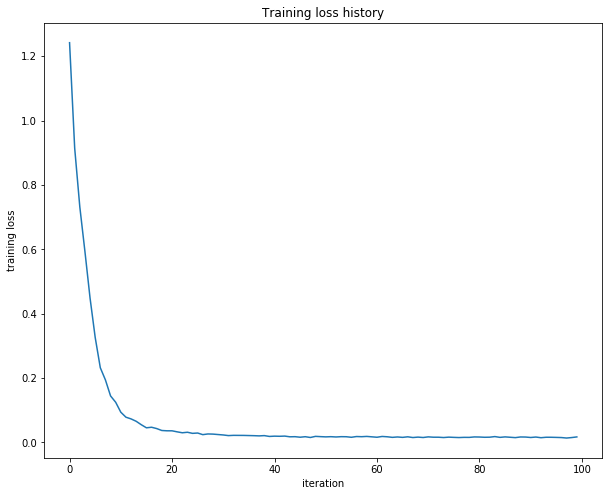

In [489]:
net = init_toy_model()
stats = net.train(X,Y,X,Y,learning_rate=1e-1, reg=1e-5, num_iters=100, verbose=False)

print 'Final training loss :', stats['loss_history'][-1]

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training loss history')
plt.show()

### Load the data

Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our CIFAR10 data so we can use it to train a classifier on a real dataset.

In [490]:
def get_CIFAR10_data():
    # 1. Load the raw data
    X_tr, Y_tr, X_te, Y_te = load_CIFAR10('./cifar-10-batches-py')
    
    # 2. Divide the data
    X_val, Y_val = X_tr[49000:], Y_tr[49000:]
    X_tr, Y_tr = X_tr[:49000], Y_tr[:49000]
    X_te, Y_te = X_te[:1000], Y_te[:1000]

    # 3. Preprocess the input image
    X_tr = np.reshape(X_tr, (X_tr.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0],-1))
    X_te = np.reshape(X_te, (X_te.shape[0],-1))
    
    # 4. Normalize the data (subtract the mean image)
    mean_img = np.mean(X_tr, axis=0)
    X_tr -= mean_img
    X_val -= mean_img
    X_te -= mean_img
    
    return X_tr, Y_tr, X_val, Y_val, X_te, Y_te



X_tr, Y_tr, X_val, Y_val, X_te, Y_te = get_CIFAR10_data()
print 'Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape)
print 'Validatoin data shape : %s,  Validation labels shape : %s' % (X_val.shape, Y_val.shape)
print 'Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape)

Train data shape : (49000, 3072),  Train labels shape : (49000,)
Validatoin data shape : (1000, 3072),  Validation labels shape : (1000,)
Test data shape : (1000, 3072),  Test labels shape : (1000,)


### Train a network

To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplyting it by a decay rate.

In [491]:
input_size = 32*32*3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_tr, Y_tr, X_val, Y_val, 1e-4, 0.95, 0.5, 1000, 200, True)

# Predict on the validation set
#val_acc = (net.predict(X_val)==Y_val).mean()
val_acc = np.mean(net.predict(X_val)==Y_val)

print 'Validation accuracy :' , val_acc

Iteration 0 / 1000 : loss 2.302954 
Iteration 100 / 1000 : loss 2.302551 
Iteration 200 / 1000 : loss 2.297649 
Iteration 300 / 1000 : loss 2.259604 
Iteration 400 / 1000 : loss 2.204187 
Iteration 500 / 1000 : loss 2.118602 
Iteration 600 / 1000 : loss 2.051566 
Iteration 700 / 1000 : loss 1.988489 
Iteration 800 / 1000 : loss 2.006616 
Iteration 900 / 1000 : loss 1.951511 
Validation accuracy : 0.287


### Debug the training

With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized. 

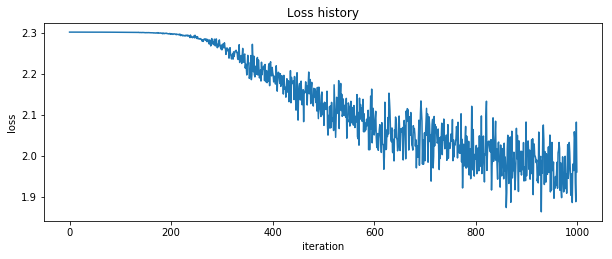

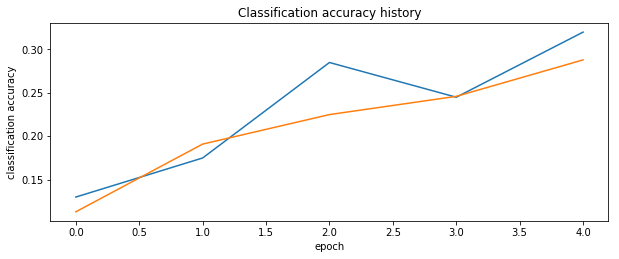

In [492]:
# Plot the loss function and train / validation accuracie
plt.subplot(2,1,1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.subplot(2,1,2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('epoch')
plt.ylabel('classification accuracy')
plt.show()

In [493]:
from math import sqrt, ceil

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in xrange(grid_size):
        x0, x1 = 0, W
        for x in xrange(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

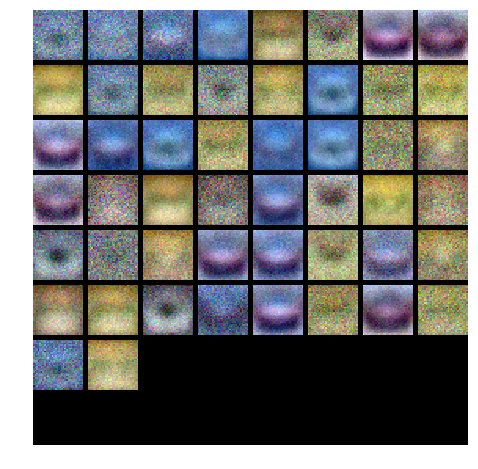

In [494]:
# Visualize the weights of the network
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32,32,3,-1).transpose(3,0,1,2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
    
show_net_weights(net)

Tuning the hyperparemeters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. You might also consider tuning the learning rate decay but, you should be able to get good performance using the default value.

You should be aim to achieve a classification accuracy of grater than 45% on the validation set.

In [510]:
best_net = None # store the best model into this 

################################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best model in best_net.      #
#                                                                                              #
# To help debug your network, it may help to use visualizations similar to the ones we used    #
# above; these visualizations will have significant qualitative differences from the ones      #
# we saw above for the poorly tuned network.                                                   #
#                                                                                              #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to write code      #
# to sweep through possible combinations of hyperparameters automatically like we did on the   #
# previous exercises.                                                                          #
#-------------------------------------WRITE YOUR CODE------------------------------------------#
input_size = 32*32*3
hidden_size = 512
num_classes = 10
train_epoch= 3
batch_size = 1024
iterations = 1500
accuracy = -1
best_stats = {}

for epoch in range(train_epoch):
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    learn_fc = np.random.uniform(-5, -1) 
    lr =  np.power(10, learn_fc)
    reg_factor = np.random.uniform(-3, -5)
    rg = np.power(10, reg_factor)
    # Train the network
    stats = net.train(X_tr, Y_tr, X_val, Y_val, learning_rate=lr, reg=rg, num_iters=iterations)

    train_acc = stats['train_acc_history'][-1]
    val_acc = stats['val_acc_history'][-1]
    if val_acc > accuracy:
        accuracy = val_acc
        best_stats = stats
        best_net = net


print "best validation accuracy {} best reg {} best learning rate {}".format(accuracy, rg, lr)
#------------------------------------END OF YOUR CODE------------------------------------------#
################################################################################################

best validation accuracy 0.46 best reg 0.000450977586402 best learning rate 2.15163160804e-05
